September 29, 2016 - Women in Data Science Meetup - "Data Science from Scratch" Workshop #8

# Data Science from Scratch Tutorial

## Playing with an SVD of an Image of Tony Blair

### Julia Galstad 2016

This notebook will demonstrate 
    1. Using the SVD to compute principal components and values for PCA directly from the data, without using the correlation matrix.
    2. What an image looks like reconstructed using various numbers of principal values.
    3. How different principal components pick out different features from an image, an example of unsupervised feature selection.
  
The image we'll use is preprocessed (by Sci-kit learn) from the dataset used in "Labeled Faces in the Wild":

  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz
  
The image is stored in ``Blair.csv``.
  
After this notebook, you may enjoy Sci-kit learn's "Faces recognition example using eigenfaces and SVMs" from http://scikit-learn.org/stable/auto_examples/applications/face_recognition.html. Facial recognition in this example is done using PCA and a support vector machine (SVM).

In [1]:
from __future__ import print_function, division 

%matplotlib notebook

from time import time
import logging
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from sklearn import preprocessing

# Display progress logs
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

### Defining a helper plot function

We'll be plotting lots of images to see what's going on. The function ``plot_gallery`` will be helpful.

In [2]:
def plot_gallery(images, titles, n_row=2, n_col=3):
    """Helper function to plot a gallery of Blair portraits
    
    images - a list of grayscale images (arrays)
    titles - a list of title of those images (strings)
    n_row, n_col - specifications for how many rows and columns of
                   images we want to display at once
    
    """
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i], cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

### Importing the image of Tony Blair

Import the data representing an image of Tony Blair's face from 'Blair.csv'. The data represents the numbers used to make a small grayscale image. 

<class 'numpy.ndarray'>
(125, 94)
[ 42.          34.          31.66666603  41.66666794  54.          52.33333206
  43.33333206  32.33333206  31.66666603  46.66666794  69.66666412
  88.33333588]


<IPython.core.display.Javascript object>


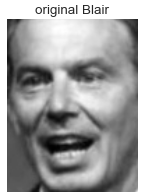

In [3]:
blair=np.genfromtxt('Blair.csv', delimiter=',') # import the image from a csv
print(type(blair))                              # the image is saved as an array
h,w = blair.shape                               # saving the size of the image
print(blair.shape)                              # the size of the array
print(blair[0, 0:12])                           # a peek into the grayscale numbers
                                                   # that create the image
plot_gallery([blair],['original Blair'], 1, 1) 
plt.show()                                      # The original Tony Blair

### Centering the Data

Use sklearn's preprocessing module to center our data, which is mandatory for PCA. If you're using a pre-made PCA algorithm, it will likely center it for you. 

Normalizing data is also often a great idea before PCA. We won't normalize our data here, although the scaler is capable of that. 

In [4]:
scaler = preprocessing.StandardScaler(with_std=False).fit(blair)
print(scaler)

StandardScaler(copy=True, with_mean=True, with_std=False)


After we center the data, we see that the scaler worked by centering each column (as opposed to each row). If your data weren't an image, you'd need to pay attention to whether or not your storing your data as one column per feature or one row per feature. Modules in ``sklearn`` are often written with the former in mind.

We have access to the array of means that were used so we could 'uncenter' the data when we're done if we like.

In [5]:
blair_centered =scaler.transform(blair)  # centering the image data
print(scaler.mean_[0:5])                 # looking at part of the first row to check
print(blair[0, 0:5])                        # we are centering columns
print(blair_centered[0, 0:5])

[ 56.94666667  58.91466678  61.40800024  66.65333366  72.88000021]
[ 42.          34.          31.66666603  41.66666794  54.        ]
[-14.94666667 -24.91466678 -29.74133421 -24.98666573 -18.88000021]


<IPython.core.display.Javascript object>


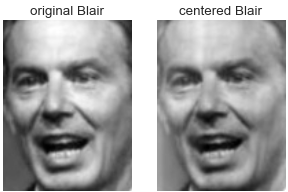

In [6]:
plot_gallery([blair, blair_centered],['original Blair', 'centered Blair'], 1, 2)
plt.show() 

### Calculate the SVD of Tony Blair's image

We factor our centered data matrix (not the covariance matrix) using the SVD.

In [7]:
t0 = time()
U, s, Vt = np.linalg.svd(blair_centered, full_matrices=True)
print(U.shape, s.shape, Vt.shape)
print("done in %0.3fs" % (time() - t0))

(125, 125) (94,) (94, 94)
done in 0.011s


Numpy's SVD algorithm saves the diagonal entries (the singular values) of $S$ as an array ``s`` for efficiency. 
However, we can always make the diagonal matrix ``S`` from ``s`` to check to see that we indeed factored our data as 
$$\rm{blair\_centered} = USV^{\dagger}.$$
(In the literature, we often notate the matrix $S$ as $\Sigma$.)

In [8]:
S = np.zeros((125, 94))
S[:94, :94] = np.diag(s)              
print(np.allclose(blair_centered, np.dot(U, np.dot(S, Vt)))) #returns True, hopefully

True


### How many principal components do we want?

We use the information the SVD to calculate the ``explained_variance_ratio``.

In [9]:
principal_values = [i**2/(h-1) for i in s]           # h is the number of rows in blair_centered
                                                     # s contains singular values from the SVD
total_variance = sum(principal_values)

# The entry explained_variance_ratio[i] indicates the ratio of variance explained by the
# ith principal value

explained_variance_ratio = [principal_value / total_variance for principal_value in principal_values]
print(explained_variance_ratio[0:15], ' ... ', explained_variance_ratio[-3:])

[0.6369271256888831, 0.1255761934134268, 0.077243519702730759, 0.038290524543542044, 0.03175904387135365, 0.026458364680816627, 0.01865088970122181, 0.0081294608285611084, 0.0071824586200982853, 0.0067551612725668363, 0.0053189990296752176, 0.0032040404379555252, 0.0026372578310756381, 0.0017655583850355295, 0.0015537796133543614]  ...  [6.377839675034383e-08, 5.3081242396222076e-08, 4.1130222301163315e-08]


The barplot of the ``cumulative_explained_variance_ratio`` shows what ratio of
variance is explained by number of principal components.

<IPython.core.display.Javascript object>


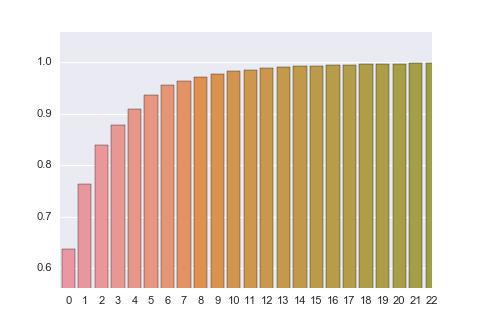

In [10]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)

cumulative_explained_variance_ratio = np.cumsum(explained_variance_ratio)

comps = range(len(cumulative_explained_variance_ratio))
lcomps = [x for x in comps]

sns.barplot(lcomps, cumulative_explained_variance_ratio)

### Use the "Zoom to Rectangle" button to answer the questions.

### How many principal components explain
    
#### 63% of the variance?
    
#### 90% of the variance?
    
#### 95% of the variance?
    
#### 99% of the variance?
    
#### 99.5% of the variance?

#### 99.8% of the variance?
    
### How many components do you think will make a 'good' image of Tony Blair? And/or an image 'fairly indistinguishable' from the original? 

If you wanted, you could make a new barplot of only a portion of ``cumulative_explained_variance_ratio``.

In [ ]:
#fig = plt.figure(figsize=(6,4))
#ax = fig.add_subplot(111)
#sns.barplot(lcomps[0:20], cumulative_explained_variance_ratio[0:20])

### Let's investigate the first 5 principal components.

In [11]:
five_PCs = [np.transpose(Vt[[i],:]) for i in range(5)]    # PCs are columns of V
                                                          # PC1 = five_PCs[0]
print(five_PCs[0].shape)

(94, 1)


To visualize what portion of the image ``blair_centered`` is represented along PC1, we first do a coordinate change to project onto that PC. Then we reconstruct that portion of the image via another coordinate change. This amounts to finding the product

``blair_centered``$\cdot{\rm PC1}\cdot{\rm PC1}^t$

In [12]:
print(np.dot(five_PCs[0], np.transpose(five_PCs[0])).shape)

image_of_fivePCs = [np.dot(blair_centered, np.dot(five_PCs[i], np.transpose(five_PCs[i]))) for i in range(5)]
print(image_of_fivePCs[0].shape)

(94, 94)
(125, 94)


### Can you see any 'facial features' represented by the first 5 PCs?

<IPython.core.display.Javascript object>


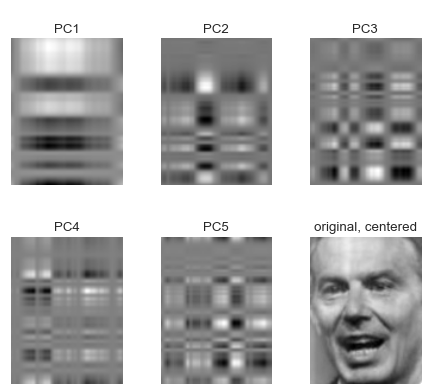

In [13]:
image_of_fivePCs.append(blair_centered)
fivePCs_titles = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'original, centered']
plot_gallery(image_of_fivePCs, fivePCs_titles)
plt.show() 

### How well do you think the image will look using between 1 and 5 PCs? 

Let's look.

done in 0.001s


<IPython.core.display.Javascript object>


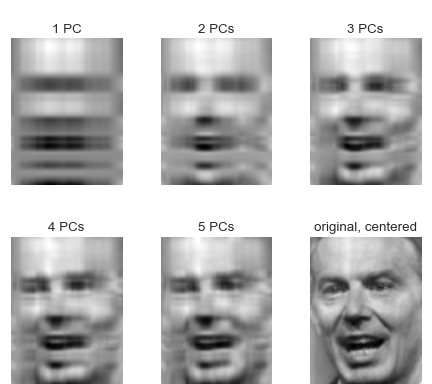

In [14]:
images = []

t0 = time()
for n_components in [1, 2, 3, 4, 5]:
    V = Vt[:n_components - w]                                           # retrieves $n$ PCs
    images.append(np.dot(blair_centered, np.dot(np.transpose(V), V)))   # projects then reconstructs

image_titles = ['1 PC', '2 PCs', '3 PCs', '4 PCs', '5 PCs', 'original, centered']
print("done in %0.3fs" % (time() - t0))

images.append(blair_centered)

plot_gallery(images, image_titles)

plt.show()

### How many components do you think will make a 'good' image of Tony Blair? And/or an image 'fairly indistinguishable' from the original? 

Earlier you conjectured based on looking at the cumulative explained variance ratio bar plot, but now let's look at the images themselves.

Let's first try images based on 2, 5, 8, 15 and 30 principal components, but run the code as many times as you like, changing the numbers of PCs.

<IPython.core.display.Javascript object>


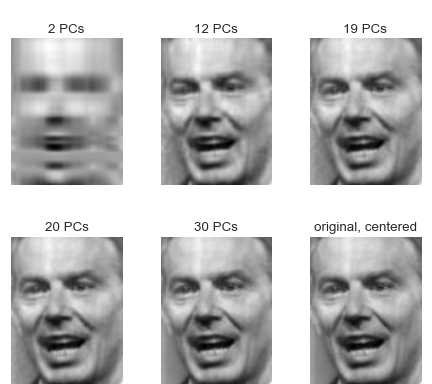

In [16]:
# constructs 5 compressed images of Tony Blair based on desired number of PCs 
# and compares to the original, centered Blair

images = []
    
for n_components in [2, 12, 19, 20, 30]:
    V = Vt[:n_components - w]                                           # retrieves $n$ PCs
    images.append(np.dot(blair_centered, np.dot(np.transpose(V), V))) # projects then reconstructs

image_titles = ['2 PCs', '12 PCs', '19 PCs', '20 PCs', '30 PCs', 'original, centered']
images.append(blair_centered)

plot_gallery(images, image_titles, 2, 3)

plt.show()

### Yay! You made it to the end of the notebook.